In [59]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *
from FRSolver import * 

%matplotlib inline

In [60]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [61]:
px2 = 0.347111 + 1e-4
py2 = 0.532728 + 1e-4

# velocity 
v1prime = np.array([px2,py2,0], dtype="float64")
v2prime = np.array([-2 * px2,-2*py2,0], dtype="float64")
v3prime = np.array([px2,py2,0], dtype="float64")

v0sprime = np.array([v1prime,v2prime,v3prime])

In [62]:
T = 2* np.pi
C = 1e-2
hlim = 1e-10


In [63]:
traj, _ = fullSolver(T, C, r0s, v0s, G, masses, hlim = hlim)
trajprime, _ = fullSolver(T, C, r0s, v0sprime, G, masses, hlim = hlim)

In [64]:
dist = np.linalg.norm(traj[1][:1665,1] - trajprime[1][:1665,1], axis = 1)

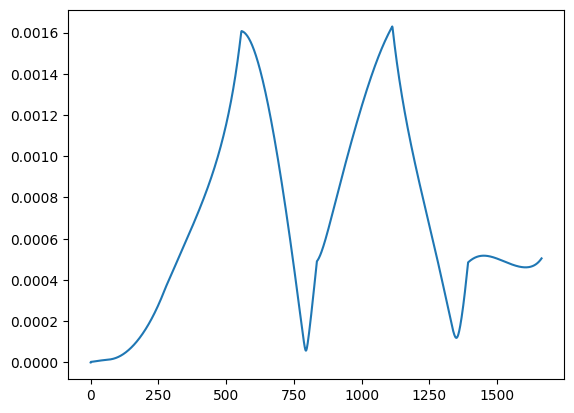

In [65]:
plt.plot(dist)